In [345]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1.1, style='white')

In [346]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [347]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 9999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 9999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 9999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 9999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [348]:
# Load data from path
web1 = pd.read_csv("../data/dataWEB/csv_experiments_WEB01.csv")
web2 = pd.read_csv("../data/dataWEB/csv_experiments_WEB02.csv")
web3 = pd.read_csv("../data/dataWEB/csv_experiments_WEB03.csv")

# do processing, renaming and selection
mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"
mapping01["param__func__de.upb.lb-nginx.0.1__mem_max"] = "Memory"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"
mapping02["param__func__de.upb.lb-haproxy.0.1__mem_max"] = "Memory"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"
mapping03["param__func__de.upb.px-squid.0.1__mem_max"] = "Memory"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

web1

C:\Users\giovanna\AppData\Local\Temp\ipykernel_14856\1204395680.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.rename(columns={k: v}, inplace=True)
C:\Users\giovanna\AppData\Local\Temp\ipykernel_14856\1204395680.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.rename(columns={k: v}, inplace=True)
C:\Users\giovanna\AppData\Local\Temp\ipykernel_14856\1204395680.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.re

,size,Max. throughput [kB/s],CPU,Memory
0,small,NaN,0.1,64
1,small,532.07,0.1,64
2,small,NaN,0.1,64
3,small,532.47,0.1,64
4,small,523.91,0.1,64
...,...,...,...,...
1595,big,1545196.78,1.0,512
1596,big,1561152.62,1.0,512
1597,big,1553702.49,1.0,512
1598,big,1587063.69,1.0,512


In [349]:
# select sub-datasets with small and large flows
# and with specific memory
mem =128

web1_small = web1.loc[(web1["size"] == "small") & (web1["Memory"] == mem)]
web1_small = web1_small[["Max. throughput [kB/s]", "CPU"]]

web1_big = web1.loc[(web1["size"] == "big")  & (web1["Memory"] == mem)]
web1_big = web1_big[["Max. throughput [kB/s]", "CPU"]]

web2_small = web2.loc[(web2["size"] == "small")  & (web2["Memory"] == mem)]
web2_small = web2_small[["Max. throughput [kB/s]", "CPU"]]
web2_big = web2.loc[(web2["size"] == "big")  & (web2["Memory"] == mem)]
web2_big = web2_big[["Max. throughput [kB/s]", "CPU"]]

web3_small = web3.loc[(web3["size"] == "small")  & (web3["Memory"] == mem)]
web3_small = web3_small[["Max. throughput [kB/s]", "CPU"]]
web3_big = web3.loc[(web3["size"] == "big")  & (web3["Memory"] == mem)]
web3_big = web3_big[["Max. throughput [kB/s]", "CPU"]]

web1_small


,Max. throughput [kB/s],CPU
40,NaN,0.1
41,541.33,0.1
42,528.56,0.1
43,545.81,0.1
44,532.16,0.1
...,...,...
1495,2323.62,1.0
1496,2280.04,1.0
1497,2329.52,1.0
1498,2311.39,1.0


In [350]:
# 20 measurements per CPU config from 0.1 to 1.0
web1_small[web1_small["CPU"] == 0.5].shape

(20, 2)

In [351]:

# add 20 "measurements" at 0 CPU and throuhgput
num_measures = 20
measures = [0 for _ in range(num_measures)]

web1_small = web1_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web1_big = web1_big.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web2_small = web2_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web2_big = web2_big.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_small = web3_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_big = web3_big.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)

In [352]:
# rename
nginx = web1_small
haproxy = web2_small
squid = web3_small

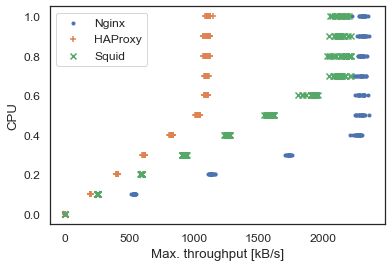

In [353]:
# proper plotting of VNF data for paper
# only use data with small flows
def plot_vnf_data():
    sns.set(font_scale=1.1, style='white')
    fig, ax = plt.subplots()
    plt.scatter(nginx['Max. throughput [kB/s]'], nginx['CPU'], label='Nginx', marker='.')
    plt.scatter(haproxy['Max. throughput [kB/s]'], haproxy['CPU'], label='HAProxy', marker='+')
    plt.scatter(squid['Max. throughput [kB/s]'], squid['CPU'], label='Squid', marker='x')

    # labels
    ax.set_xlabel('Max. throughput [kB/s]')
    ax.set_ylabel('CPU')
    plt.legend()
    
plot_vnf_data()

In [354]:
def cross_validation_rmse(model, X, y, vnf_name, k=5, save_model=False):
    """Do k-fold CV and return the avg RMSE on the validation set. Train and save the model."""
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    name = type(model).__name__
    print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})")  
    if save_model:
        model.fit(X, y)
        joblib.dump(model, f'ml_models/{vnf_name}/{name}.joblib')
    return rmse 

def tune_hyperparams(model, X, y, params):
    """Do grid search CV for hyperparam tuning and return CV RMSE"""
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)   
    return grid_search.best_estimator_

def barplot_rmse(scores, labels, data_name):
    """bar plot comparing the RMSE of the different algorithms"""
    sns.set(font_scale=1.1, style='white')
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots() #figsize = (8, 6))
    plt.barh(x, rmse_mean, color='grey', xerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('RMSE')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

In [355]:
def train_eval_models(X, y, vnf_name, tune_params=False):
    """Create, tune, eval, and return all ML models"""
    # prepare models
    labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
    models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
              GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
              FixedModel(fixed_value=0.8)]
    
    # params for tuning
    params_ridge = {'alpha': [0.1, 1, 10]}
    params_svr = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 100], 
                  'epsilon': [0.001, 0.01, 0.1]}
    params_forest = {'n_estimators': [10, 100, 200]}
    params_boosting = {'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [10, 100, 200]}
    params_mlp = {'hidden_layer_sizes': [(64,), (128,), (256)], 'alpha': [0.001, 0.0001, 0.00001],
                  'learning_rate_init': [0.01, 0.001, 0.0001]}
    params = [{}, params_ridge, params_svr, params_forest, params_boosting, params_mlp, {}]
    
    # tune, train, eval
    if tune_params:
        models = [tune_hyperparams(models[i], X, y, params[i]) for i in range(len(models))]  
    rmse = [cross_validation_rmse(model, X, y, vnf_name, save_model=True) for model in models]
    
    # plot
    if tune_params:
        barplot_rmse(rmse, labels, f'{vnf_name}_tuned')
    else:
        barplot_rmse(rmse, labels, f'{vnf_name}_default')
        
    return models

In [356]:
def prepare_data(data, vnf_name):
    """Split return data"""
    X = data[['Max. throughput [kB/s]']]
    y = data['CPU']
    X = X.fillna(X.median())

    scaler = MinMaxScaler()
    scaler.fit(X)
    os.makedirs(f'ml_models/{vnf_name}', exist_ok=True)
    joblib.dump(scaler, f'ml_models/{vnf_name}/scaler.joblib')
    
    return X, y, scaler

In [361]:
def predict_plot_all(models, scaler, X, y, vnf_name):
    """Given a list of models, fit all to the data, save model, and plot their predictions"""
    sns.set(font_scale=1.1, style='white')
    
    models = [models[3], models[4]] #tolto models[6]
    labels = ['Forest', 'Boosting'] # levo 'Fixed'
    markers = ['v', '^'] #levo '+'
    colors = ['blue', 'green'] # levo orange
    
    fig, ax = plt.subplots()    
    plt.scatter(X, y, label='Data', marker='o', color='black', s=50)
    X = scaler.transform(X)
    times = []
    for i, model in enumerate(models):
        # train model
        name = type(model).__name__
        model.fit(X, y)
        os.makedirs(f'ml_models/{vnf_name}', exist_ok=True)
        # predict and plot data
        X_plot = pd.DataFrame({'Max. Throughput [kB/s]': np.arange(200, 2500, 50)})
        X_plot_scaled = scaler.transform(X_plot)
        start = time.time()
        y_pred = model.predict(X_plot_scaled)
        times.append(start - time.time())
        plt.scatter(X_plot, y_pred, label=labels[i], marker=markers[i])

    plt.xlabel('Traffic Load [kB/s]')
    plt.ylabel('CPU')
    plt.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend()
    # save, avoid cutting off labels
    plt.tight_layout()
    #fig.savefig(f'plots/{vnf_name}_model_comparison.pdf')
    
    # return prediction times
    return times

In [358]:
def barplot_compare_rmse(scores_default, scores_tuned, labels, data_name):
    """
    bar plot comparing the RMSE of the different algorithms also compare against tuned version of algorithms    
    """
    sns.set(font_scale=1.1, style='white')
    assert len(scores_default) == len(scores_tuned) == len(labels)
    
    x = np.arange(len(labels))
    width = 0.35

    # plot
    fig, ax = plt.subplots() # prev: figsize = (8, 5))
    
    # default
    rmse_mean = [s.mean() for s in scores_default]
    rmse_std = [s.std() for s in scores_default]
    # 95% CI (not bootstrapped like seaborn does): https://en.wikipedia.org/wiki/Confidence_interval#Basic_steps
    ci95 = [1.96 * std / np.sqrt(len(rmse_std)) for std in rmse_std]
    ax.bar(x - width/2, rmse_mean, width, yerr=ci95, capsize=5, color='gray', label='Default')
    
    # same for tuned version
    rmse_mean = [s.mean() for s in scores_tuned]
    rmse_std = [s.std() for s in scores_tuned]
    # 95% CI (not bootstrapped like seaborn does): https://en.wikipedia.org/wiki/Confidence_interval#Basic_steps
    ci95 = [1.96 * std / np.sqrt(len(rmse_std)) for std in rmse_std]
    ax.bar(x + width/2, rmse_mean, width, yerr=ci95, capsize=5, color='lightgray', label='Tuned')
        
    # labels
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=False, left=True, right=True, top=False)
    ax.legend()
    
    #fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

In [359]:
def train_tune_eval_models(X, y, vnf_name):
    """Create, tune, eval, and return all ML models - compare default vs tuned performance"""
    # prepare models and rmse without tuning
    labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP'] #'Fixed' tolta
    models_default = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
              GradientBoostingRegressor(), MLPRegressor(max_iter=1500) ]  #FixedModel(fixed_value=0.8) aggiunta a tutti 
    rmse_default = [cross_validation_rmse(model, X, y, vnf_name, save_model=False) for model in models_default]
    
    # hyperparam tuning
    params_ridge = {'alpha': [0.1, 1, 10]}
    params_svr = {'kernel': ['poly', 'rbf'], 'C': [1, 10, 100], 
                  'epsilon': [0.001, 0.01, 0.1]}
    params_forest = {'n_estimators': [10, 100, 200]}
    params_boosting = {'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [10, 100, 200]}
    params_mlp = {'hidden_layer_sizes': [(64,), (128,), (256)], 'alpha': [0.001, 0.0001, 0.00001],
                  'learning_rate_init': [0.01, 0.001, 0.0001]}
    params = [{}, params_ridge, params_svr, params_forest, params_boosting, params_mlp, {}]

    models_tuned = [tune_hyperparams(models_default[i], X, y, params[i]) for i in range(len(labels))] 
#     models_tuned = [tune_hyperparams(models_default[i], X, y, {}) for i in range(len(labels))]
    rmse_tuned = [cross_validation_rmse(model, X, y, vnf_name, save_model=True) for model in models_tuned]
    
    # plot and compare
    barplot_compare_rmse(rmse_default, rmse_tuned, labels, f'{vnf_name}_default-tuned')
        
    return models_tuned

CV RMSE of LinearRegression: 0.22067391080810847 (+/-0.07199591952600828)
CV RMSE of Ridge: 0.2205383812782431 (+/-0.07177287732372464)
CV RMSE of SVR: 0.26174465586135287 (+/-0.05876173341432028)
CV RMSE of RandomForestRegressor: 0.221413278688862 (+/-0.06020332432088711)
CV RMSE of GradientBoostingRegressor: 0.21747601079878964 (+/-0.05579023772834299)
CV RMSE of MLPRegressor: 0.2276735568946588 (+/-0.07091923768919897)
CV RMSE of LinearRegression: 0.22067391080810847 (+/-0.07199591952600828)
CV RMSE of Ridge: 0.2205383812782431 (+/-0.07177287732372464)
CV RMSE of SVR: 0.23975356540594114 (+/-0.036456669991004664)
CV RMSE of RandomForestRegressor: 0.22156659255547373 (+/-0.06011725080651463)
CV RMSE of GradientBoostingRegressor: 0.19971560243285214 (+/-0.050959613749022394)
CV RMSE of MLPRegressor: 0.22833611328468345 (+/-0.07707803364611875)


[-0.005903005599975586, 0.0]

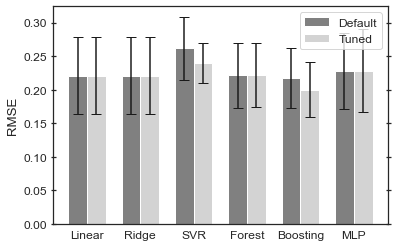

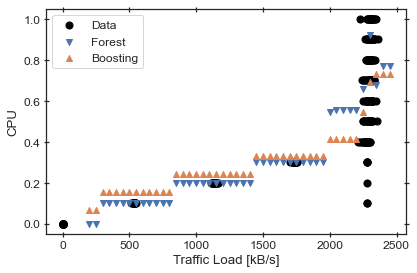

In [362]:
vnf_name = 'nginx'
X, y, scaler = prepare_data(nginx, vnf_name)
X_scaled = scaler.transform(X)

models = train_tune_eval_models(X_scaled, y, vnf_name)
predict_plot_all(models, scaler, X, y, vnf_name)

In [ ]:
vnf_name = 'haproxy'
X, y, scaler = prepare_data(haproxy, vnf_name)
X_scaled = scaler.transform(X)

models = train_tune_eval_models(X_scaled, y, vnf_name)
predict_plot_all(models, scaler, X, y, vnf_name)

In [ ]:
vnf_name = 'squid'
X, y, scaler = prepare_data(squid, vnf_name)
X_scaled = scaler.transform(X)

models = train_tune_eval_models(X_scaled, y, vnf_name)
predict_plot_all(models, scaler, X, y, vnf_name)

# INIZIO LO STUDIO DEL RANDOM FOREST UNICO 

# - NGINX

In [126]:
dfRandForestNGINX = pd.read_csv("../data/dataWEB/NGINX_data_chart.csv")
dfRandForestNGINX.head()

,size,cpu_bw,mem,requests_per_second,completed_requests,failed_requests,html_transfer_byte,mean_time_per_request,total_transfer_byte,transfer_rate_kbyte_per_second,rx_bytes,rx_packets,tx_bytes,tx_packets,vnf
0,0,0.1,64,0.00,0.0,0.0,0.0,0.000,0.0,0.00,40643684.0,113005.0,19184806.0,112879.0,nginx
1,0,0.1,64,1783.06,107128.0,0.0,0.0,0.561,32734529.0,532.07,40102485.0,111501.0,18929278.0,111377.0,nginx
2,0,0.1,64,0.00,0.0,0.0,0.0,0.000,0.0,0.00,38883453.0,108114.0,18354072.0,107992.0,nginx
3,0,0.1,64,1784.42,107065.0,0.0,0.0,0.560,32715251.0,532.47,40079181.0,111440.0,18918184.0,111312.0,nginx
4,0,0.1,64,1755.71,105343.0,0.0,0.0,0.570,32189066.0,523.91,39434018.0,109644.0,18614022.0,109525.0,nginx


In [127]:
x= dfRandForestNGINX.drop(["cpu_bw","vnf"],axis=1)

In [128]:
y= dfRandForestNGINX["cpu_bw"]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)   #ci stava 0.2

In [130]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [131]:
from sklearn.ensemble import RandomForestRegressor
#RANDOM FOREST  NGINX

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [144]:
y_test

320

In [140]:
y_pred

array([0.7  , 0.3  , 1.   , 0.6  , 0.494, 0.3  , 0.736, 0.645, 0.9  ,
       0.1  , 0.71 , 0.744, 1.   , 0.1  , 0.2  , 0.1  , 0.672, 0.2  ,
       0.9  , 0.1  , 0.505, 0.1  , 0.3  , 0.8  , 0.578, 0.4  , 0.7  ,
       0.2  , 1.   , 0.759, 0.734, 0.3  , 0.7  , 0.7  , 0.4  , 0.2  ,
       1.   , 0.9  , 0.3  , 0.1  , 0.754, 0.8  , 0.3  , 0.9  , 0.8  ,
       0.4  , 0.5  , 0.9  , 0.5  , 0.47 , 0.875, 0.3  , 0.8  , 0.1  ,
       0.732, 0.5  , 0.886, 0.858, 0.1  , 0.905, 0.753, 0.9  , 0.808,
       0.662, 0.6  , 0.1  , 0.854, 0.5  , 0.703, 0.4  , 0.545, 0.2  ,
       0.1  , 0.834, 0.1  , 0.5  , 0.9  , 0.2  , 0.5  , 0.1  , 0.8  ,
       0.437, 0.6  , 0.827, 0.3  , 0.79 , 0.2  , 0.524, 0.5  , 0.1  ,
       0.8  , 0.759, 0.732, 0.4  , 1.   , 0.8  , 0.9  , 0.2  , 0.589,
       0.3  , 0.481, 1.   , 0.2  , 0.73 , 0.7  , 0.9  , 0.1  , 0.652,
       0.2  , 0.4  , 0.3  , 1.   , 0.4  , 0.8  , 0.4  , 0.5  , 0.299,
       0.559, 0.2  , 0.8  , 0.831, 0.9  , 0.5  , 0.2  , 0.1  , 0.4  ,
       0.57 , 0.6  ,

In [305]:
IDs=[]
for i in range(0,320):
    IDs.append(i)
print(IDs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [308]:
#creo un dataframe per vedere il confronto tra i dati di test e quelli di predizione fra cpu bandwith 
dfConfrontoNGINX = pd.DataFrame({'ID experiment':IDs ,'CPU BW allocated':y_test, 'CPU BW RandomForest':y_pred , 'CPU BW Boosting' : pred1})
dfConfrontoNGINX.head(20)

,ID experiment,CPU BW allocated,CPU BW RandomForest,CPU BW Boosting
1073,0,0.7,0.700,0.701411
326,1,0.3,0.300,0.303404
1557,2,1.0,1.000,0.995892
918,3,0.6,0.600,0.601899
974,4,0.7,0.494,0.543492
473,5,0.3,0.300,0.321989
1005,6,0.7,0.736,0.722186
737,7,0.5,0.645,0.597051
1426,8,0.9,0.900,0.897713
53,9,0.1,0.100,0.105432


In [309]:
score = regressor.score(X_test,y_test)
score

0.819812233492406

In [319]:
from sklearn import metrics
#RANDOM FOREST  NGINX

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.05930625000000043
Mean Squared Error: 0.015516137500000022
Root Mean Squared Error: 0.12456378887943326


In [320]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.819812233492406

In [333]:
from sklearn.ensemble import VotingRegressor
# Train classifiers
reg1 = GradientBoostingRegressor(random_state=0)
reg2 = RandomForestRegressor(random_state=0)

reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)

ereg = VotingRegressor([("gb", reg1), ("rf", reg2)])
ereg.fit(X_train, y_train)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=0)),
                            ('rf', RandomForestRegressor(random_state=0))])

In [343]:
xt = X_test[:22]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred4 = ereg.predict(xt)

pred3 = dfConfrontoNGINX.iloc[0:30,1:2]
pred1.size


22

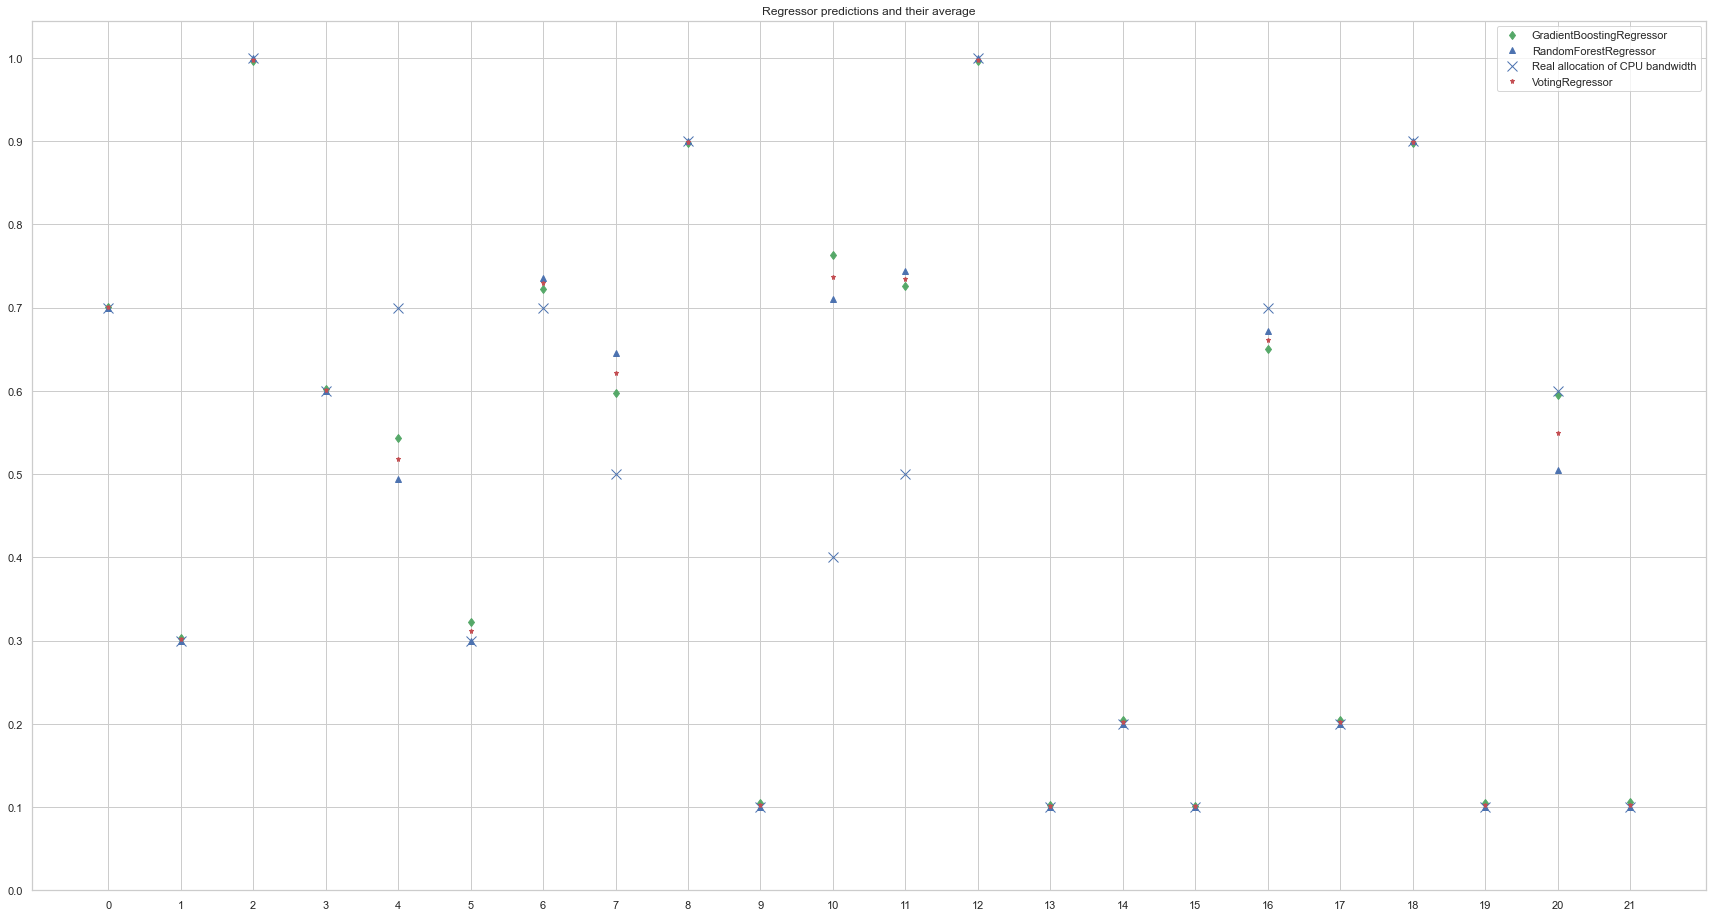

In [344]:
plt.figure(figsize=(30,16))
plt.plot(pred1, "gd", label="GradientBoostingRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(cpu_allocata, "x", ms=10 ,label='Real allocation of CPU bandwidth')
plt.plot(pred4, "r*", ms=5, label="VotingRegressor")


#plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
#plt.ylabel("predicted")
#plt.xlabel("training samples")
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.xticks(np.arange(22))
plt.legend(loc="best")
plt.title("Regressor predictions and their average")
plt.grid(True)

plt.show()

In [341]:
array_cpu = dfConfrontoNGINX['CPU BW allocated'].to_numpy() #ho convertito in questo modo in array i valori della cpu allocati . 
cpu_allocata=[]
for i in range(0,22):
    cpu_allocata.append(array_cpu[i])

In [314]:
#GRADIENT BOOST NGINX 
regressorBoost = GradientBoostingRegressor(n_estimators=100, random_state=0)
regressorBoost.fit(X_train, y_train)
y_pred2 = regressorBoost.predict(X_test)

In [318]:
#GRADIENT BOOST NGINX 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Mean Absolute Error: 0.0559695466155811
Mean Squared Error: 0.012020122324852287
Root Mean Squared Error: 0.10963631845721694


In [316]:
r2_score(y_test, y_pred2)

0.860411201250105

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

### CONFIGURATION PARAMETERS RANDOM FOREST
param_dist = [{"max_depth": [2,3,12,None],
              "min_samples_split": [10,50],
              "min_samples_leaf": [10,50],
              "bootstrap": [True, False],
              "criterion":['squared_error'],
             }]
metrics_reg = [
        "explained_variance",
        "max_error",
        "neg_mean_absolute_error",
         "neg_mean_squared_error",
         "neg_root_mean_squared_error",
         "neg_mean_squared_log_error",
    "r2",
   
]
n_estimators=50
for metrica in metrics_reg:
    clr =  RandomForestRegressor(n_estimators=n_estimators,
                max_features=len(dfRandForestNGINX.columns))
    grid_search = GridSearchCV(estimator=clr,  param_grid=param_dist,
                                        n_jobs=3, 
                                        scoring=metrica)


    train_set, test_set, train_label, test_label = train_test_split(x, y, test_size=0.20)
    grid_search.fit(train_set,train_label)
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print(str(n_estimators)+";"+str(len(dfRandForestNGINX.columns))+";",end='')
    for param in param_dist[0].keys():
            print(str(grid_search.best_params_[param])+";",end='')
    print(metrica+";"+'nginx'+";"+str(grid_search.best_score_),end='')
    print()
    if(metrica=='r2'):
        plt.figure(figsize=(60,20))  
        _ = tree.plot_tree(grid_search.best_estimator_[0], feature_names = dfRandForestNGINX.columns, 
                        filled=True, fontsize=20, rounded = True)
        plt.show()


# - HAPROXY

In [ ]:
dfRandForestHAPROXY = pd.read_csv("../data/dataWEB/HAPROXY_data_chart.csv")
dfRandForestHAPROXY.head()

In [ ]:
x2= dfRandForestHAPROXY.drop(["cpu_bw","vnf"],axis=1)

In [ ]:
y2= dfRandForestHAPROXY["cpu_bw"]

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=0)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#RANDOM FOREST HAPROXY

regressor2 = RandomForestRegressor(n_estimators=100, random_state=0)
regressor2.fit(X2_train, y2_train)
y2_pred = regressor2.predict(X2_test)

In [ ]:
r2_score(y2_test, y2_pred)

In [ ]:
from sklearn import metrics
#RANDOM FOREST  HAPROXY

print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))

In [ ]:
#GRADIENT BOOST HAPROXY 
regressorBoost2 = GradientBoostingRegressor(n_estimators=100, random_state=0)
regressorBoost2.fit(X2_train, y2_train)
y2_predB = regressorBoost2.predict(X2_test)

In [ ]:
r2_score(y2_test, y2_predB)

In [ ]:
#GRADIENT BOOST HAPROXY 
print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_predB))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_predB))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_predB)))

# - SQUID

In [ ]:
dfRandForestSQUID = pd.read_csv("../data/dataWEB/SQUID_data_chart.csv")
dfRandForestSQUID.head()

In [ ]:
x3= dfRandForestSQUID.drop(["cpu_bw","vnf"],axis=1)

In [ ]:
y3= dfRandForestSQUID["cpu_bw"]

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.2, random_state=0)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X3_train = sc.fit_transform(X3_train)
X3_test = sc.transform(X3_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#RANDOM FOREST HAPROXY

regressor3 = RandomForestRegressor(n_estimators=100, random_state=0)
regressor3.fit(X3_train, y3_train)
y3_pred = regressor3.predict(X3_test)

In [ ]:
r2_score(y3_test, y3_pred)

In [ ]:
from sklearn import metrics
#RANDOM FOREST  SQUID

print('Mean Absolute Error:', metrics.mean_absolute_error(y3_test, y3_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y3_test, y3_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y3_test, y3_pred)))

In [ ]:
#GRADIENT BOOST SQUID 
regressorBoost3 = GradientBoostingRegressor(n_estimators=100, random_state=0)
regressorBoost3.fit(X3_train, y3_train)
y3_predB = regressorBoost3.predict(X3_test)

In [ ]:
r2_score(y3_test, y3_predB)

In [ ]:
#GRADIENT BOOST SQUID 
print('Mean Absolute Error:', metrics.mean_absolute_error(y3_test, y3_predB))
print('Mean Squared Error:', metrics.mean_squared_error(y3_test, y3_predB))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y3_test, y3_predB)))

# MOSQUITTO

In [ ]:
dfm = pd.read_csv("../data/dataIoT/MOSQUITTO_data_chart.csv")
dfm.head()

In [ ]:
dfm["req_type"]=dfm["req_type"].replace(["malaria publish -t -n 10000 -H 20.0.0.254 -q 1 --json /tngbench_share/malaria.json"],1) 
dfm["req_type"]=dfm["req_type"].replace(["malaria publish -t -n 10000 -H 20.0.0.254 -q 2 --json /tngbench_share/malaria.json"],2)
dfm["req_type"]=dfm["req_type"].replace(["malaria publish -s 10 -n 10000 -H 20.0.0.254 --json /tngbench_share/malaria.json"],3)
dfm["req_type"]=dfm["req_type"].replace(["malaria publish -s 10000 -n 10000 -H 20.0.0.254 --json /tngbench_share/malaria.json"],4)

dfm

In [ ]:
x4= dfm.drop(["cpu_bw","mal_test_complete"],axis=1)

In [ ]:
y4= dfm["cpu_bw"]

In [ ]:
X4_train, X4_test, y4_train, y4_test = train_test_split(x4, y4, test_size=0.2, random_state=0)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X4_train = sc.fit_transform(X4_train)
X4_test = sc.transform(X4_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#RANDOM FOREST MOSQUITTO

regressor4 = RandomForestRegressor(n_estimators=100, random_state=0)
regressor4.fit(X4_train, y4_train)
y4_pred = regressor4.predict(X4_test)

In [ ]:
r2_score(y4_test, y4_pred)

In [ ]:
from sklearn import metrics
#RANDOM FOREST  MOSQUITTO

print('Mean Absolute Error:', metrics.mean_absolute_error(y4_test, y4_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y4_test, y4_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y4_test, y4_pred)))

In [ ]:
from sklearn import tree
tree.plot_tree(regressor4.estimators_[0])

In [ ]:
#GRADIENT BOOSTING MOSQUITTO

regressor4Boost = GradientBoostingRegressor(n_estimators=100, random_state=0)
regressor4Boost.fit(X4_train, y4_train)
y4_predBoost = regressor4Boost.predict(X4_test)

In [ ]:
r2_score(y4_test, y4_predBoost)

In [ ]:
#GRADIENT BOOST SQUID 
print('Mean Absolute Error:', metrics.mean_absolute_error(y4_test, y4_predBoost))
print('Mean Squared Error:', metrics.mean_squared_error(y4_test, y4_predBoost))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y4_test, y4_predBoost)))